# Identifying Particles

Import necessary python libraries

In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

In [2]:
import deeptrack as dt
import keras
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# from random import randint 

import random
random.seed(14)

print("Import Complete")

Import Complete


## Loading in Images
Graph images, verify that the gold-standard center is accurate enough

[[48.5      50.5       0.55125 ]
 [48.5      54.5       0.55125 ]
 [48.5      52.5       0.55125 ]
 ...
 [51.5      52.5       0.077995]
 [51.5      50.5       0.077995]
 [51.5      51.5       0.077995]]
[48.5     50.5      0.55125]


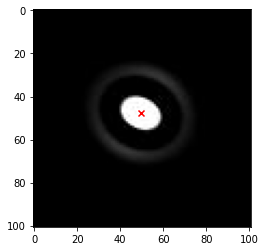

In [3]:
# Load in single image
img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image1.jpg')

# Convert to DeepTrack 2.0 Feature
img_data = dt.features.Dataset(img_data)
output_image = img_data.resolve()

# Display image
plt.imshow(output_image)

# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset)

dataset = dataset / 2.0
print(dataset[:, 0:5])

label = dataset[0]
print(label)

# Plot single image against label position
plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(label[1] - 1, label[0] - 1, c="r", marker="x") # 1-indexed, compensate with -1
plt.show()

Finished loading all images
[48.5     50.5      0.55125]


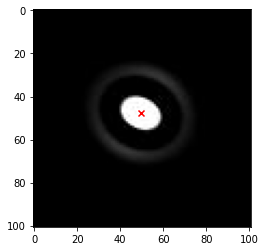

[48.5     50.5      0.55125]


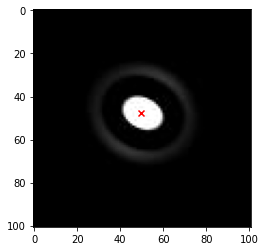

[50.5     50.5      0.63115]


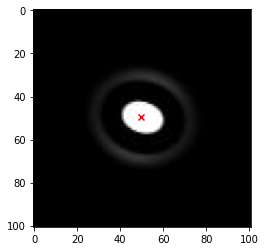

[49.5      52.5       0.077995]


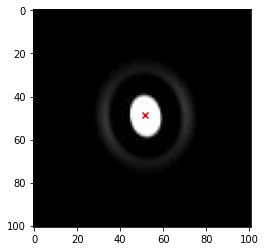

In [4]:
# ==========================================
# Load in all images
NUM_OF_IMAGES = 1000
all_images = []
for i in range(0, NUM_OF_IMAGES):
    image_name = 'image' + str(i + 1) + '.jpg'
#     print("Loading in an image named", image_name)
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/' + image_name)
    all_images.append(img_data)

print("Finished loading all images")

img_data = all_images[0]
img_data = dt.features.Dataset(img_data)

output_image = img_data.resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')
# plt.show()

# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset, dtype="float64")
dataset = dataset / 2.0

# ==========================================
# Sample a few points to show the true label
chosen = [0, 6, 266, 977]
for i in chosen:
    # Select image plot
    img_data = all_images[i]
    img_data = dt.features.Dataset(img_data)
    output_image = img_data.resolve()
    
    # Display image grayscale
    plt.imshow(np.squeeze(output_image), cmap='gray')
    
    # Load in label for selected data
    label = dataset[i]
    print(label)

    # Show image with true label
    plt.imshow(np.squeeze(output_image), cmap='gray')
    plt.scatter(label[1] - 1, label[0] - 1, c="r", marker="x") # 1-indexed, compensate with -1
    plt.show()
original_all_images = all_images.copy()



(1000, 101, 101)


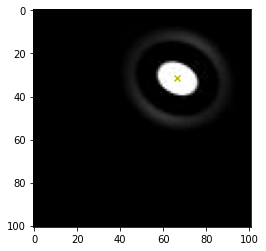

In [5]:
max_width = 101
# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset, dtype="float64")
dataset = dataset / 2.0
new_all_images = [] # 57x57
# random range is 0-44

old_label = []
for i in range(1, 1001):
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image' + str(i) + '.jpg')
    # print(img_data)
    C = img_data[22:-22, 22:-22]
# print(C)
    rand_x = random.randint(0, 44)
    rand_y = random.randint(0, 44)
    
    D = np.pad(C, ((rand_x, max_width - 57 - rand_x), (rand_y, max_width - 57 - rand_y)), 'constant')
#     print("Old coordinates were ", dataset[0], "Change by", rand_x, rand_y)
    old_label = dataset[0].copy()
    dataset[i - 1] = [dataset[i - 1][0] - 22 + rand_x, dataset[i - 1][1] - 22 + rand_y, dataset[i - 1][2]]
#     print("New coordinates are ", dataset[0])
    
    new_all_images.append(D)
#     plt.imshow(np.squeeze(D), cmap='gray')
#     plt.show()
    
new_all_images = np.array(new_all_images)
print(new_all_images.shape)
# print(new_all_images.shape)
plt.imshow(np.squeeze(new_all_images[0]), cmap='gray')
label = dataset[0]
plt.scatter(label[1] - 1, label[0] - 1, c="y", marker="x") # 1-indexed, compensate with -1
# plt.scatter(old_label[1] - 1, old_label[0] - 1, c="g", marker="x") # 1-indexed, compensate with -1
plt.show()

In [6]:
# # The generator part
# for i in range(0, len(all_images)):
#     img_data = all_images[i] #all_images[0]
#     label = dataset[i]
#     img_data = dt.features.Dataset(img_data)
#     img_data.properties.setdefault('position', [label[1] - 1, label[0] - 1])
#     # print(img_data.properties)
#     all_images[0] = img_data
# all_images = np.array(all_images)

## Training NN
It seems like the labels can only be a single value, so the way it is currently working on it, is to have a separate CNN for x- and y- labels. When combined, they will give the center position attribute for the cell.

In [7]:
x_model = dt.models.convolutional(
    input_shape=(101, 101, 1), 
    conv_layers_dimensions=(1,),
#     dense_top=False,
    activation_function="relu", # flatten it too (? maybe use standard keras here)
    number_of_outputs=1,
    loss='mean_absolute_error',
    optimiser='adam',
    metrics=['accuracy'],
    output_activation="linear",
)

print("Model summary:")
x_model.summary()

Model summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 101, 101, 1)       10        
_________________________________________________________________
activation (Activation)      (None, 101, 101, 1)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2601)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                83264     
_________________________________________________________________
activation_1 (Activation)    (None, 32)       

In [8]:
# scaling = StandardScaler()
# scaling.fit(original_all_images)
# original_all_images = scaling.transform(original_all_images)

# original_all_images = np.array(original_all_images)
# all_images = tf.convert_to_tensor(original_all_images)



# Labels into individual sets.
x_dataset = np.zeros(1000)
y_dataset = np.zeros(1000)
angle_dataset = np.zeros(1000)

count = 0
for elem in dataset:
    x_dataset[count] = elem[0]
    y_dataset[count] = elem[1]
    count += 1

X_train, X_test, Y_train, Y_test = train_test_split(new_all_images, x_dataset, shuffle=False)

# Data
all_images = tf.convert_to_tensor(new_all_images)

# x-coordinate position labels
x_dataset = tf.convert_to_tensor(x_dataset)

# all labels
# dataset = tf.convert_to_tensor(dataset)

In [9]:
print("Fitting the model")
history = x_model.fit(
    x=all_images,
    y=x_dataset,
    epochs=500,
    validation_split=0.4
)

print("Model finished fitting")

Fitting the model
Epoch 1/500
19/19 [==============================] - 1s 34ms/step - loss: 46.2873 - accuracy: 0.0000e+00 - val_loss: 45.7575 - val_accuracy: 0.0000e+00
Epoch 2/500
19/19 [==============================] - 1s 28ms/step - loss: 43.4136 - accuracy: 0.0000e+00 - val_loss: 43.8298 - val_accuracy: 0.0000e+00
Epoch 3/500
19/19 [==============================] - 1s 28ms/step - loss: 41.8761 - accuracy: 0.0000e+00 - val_loss: 42.6527 - val_accuracy: 0.0000e+00
Epoch 4/500
19/19 [==============================] - 1s 27ms/step - loss: 40.8619 - accuracy: 0.0000e+00 - val_loss: 41.7638 - val_accuracy: 0.0000e+00
Epoch 5/500
19/19 [==============================] - 1s 28ms/step - loss: 40.0218 - accuracy: 0.0000e+00 - val_loss: 40.9649 - val_accuracy: 0.0000e+00
Epoch 6/500
19/19 [==============================] - 1s 28ms/step - loss: 39.2462 - accuracy: 0.0000e+00 - val_loss: 40.2116 - val_accuracy: 0.0000e+00
Epoch 7/500
19/19 [==============================] - 1s 28ms/step - lo

19/19 [==============================] - 0s 27ms/step - loss: 14.0356 - accuracy: 0.0000e+00 - val_loss: 14.6246 - val_accuracy: 0.0000e+00
Epoch 55/500
19/19 [==============================] - 0s 26ms/step - loss: 13.8733 - accuracy: 0.0000e+00 - val_loss: 14.4139 - val_accuracy: 0.0000e+00
Epoch 56/500
19/19 [==============================] - 0s 26ms/step - loss: 13.7126 - accuracy: 0.0000e+00 - val_loss: 14.2015 - val_accuracy: 0.0000e+00
Epoch 57/500
19/19 [==============================] - 1s 28ms/step - loss: 13.5610 - accuracy: 0.0000e+00 - val_loss: 14.0129 - val_accuracy: 0.0000e+00
Epoch 58/500
19/19 [==============================] - 1s 27ms/step - loss: 13.4181 - accuracy: 0.0000e+00 - val_loss: 13.8377 - val_accuracy: 0.0000e+00
Epoch 59/500
19/19 [==============================] - 0s 26ms/step - loss: 13.2829 - accuracy: 0.0000e+00 - val_loss: 13.6555 - val_accuracy: 0.0000e+00
Epoch 60/500
19/19 [==============================] - 0s 26ms/step - loss: 13.1546 - accuracy: 

19/19 [==============================] - 0s 26ms/step - loss: 11.4907 - accuracy: 0.0000e+00 - val_loss: 11.2598 - val_accuracy: 0.0000e+00
Epoch 108/500
19/19 [==============================] - 0s 26ms/step - loss: 11.4856 - accuracy: 0.0000e+00 - val_loss: 11.2507 - val_accuracy: 0.0000e+00
Epoch 109/500
19/19 [==============================] - 1s 27ms/step - loss: 11.4840 - accuracy: 0.0000e+00 - val_loss: 11.2460 - val_accuracy: 0.0000e+00
Epoch 110/500
19/19 [==============================] - 0s 26ms/step - loss: 11.4813 - accuracy: 0.0000e+00 - val_loss: 11.2445 - val_accuracy: 0.0000e+00
Epoch 111/500
19/19 [==============================] - 0s 27ms/step - loss: 11.4824 - accuracy: 0.0000e+00 - val_loss: 11.2452 - val_accuracy: 0.0000e+00
Epoch 112/500
19/19 [==============================] - 0s 26ms/step - loss: 11.4798 - accuracy: 0.0000e+00 - val_loss: 11.2424 - val_accuracy: 0.0000e+00
Epoch 113/500
19/19 [==============================] - 0s 26ms/step - loss: 11.4791 - accu

Epoch 161/500
19/19 [==============================] - 0s 26ms/step - loss: 3.7555 - accuracy: 0.0000e+00 - val_loss: 4.1735 - val_accuracy: 0.0000e+00
Epoch 162/500
19/19 [==============================] - 0s 26ms/step - loss: 3.6337 - accuracy: 0.0000e+00 - val_loss: 4.1576 - val_accuracy: 0.0000e+00
Epoch 163/500
19/19 [==============================] - 0s 26ms/step - loss: 3.5680 - accuracy: 0.0000e+00 - val_loss: 4.1230 - val_accuracy: 0.0000e+00
Epoch 164/500
19/19 [==============================] - 1s 27ms/step - loss: 3.4887 - accuracy: 0.0000e+00 - val_loss: 3.9186 - val_accuracy: 0.0000e+00
Epoch 165/500
19/19 [==============================] - 1s 27ms/step - loss: 3.3952 - accuracy: 0.0000e+00 - val_loss: 3.9124 - val_accuracy: 0.0000e+00
Epoch 166/500
19/19 [==============================] - 0s 26ms/step - loss: 3.3402 - accuracy: 0.0000e+00 - val_loss: 3.8073 - val_accuracy: 0.0000e+00
Epoch 167/500
19/19 [==============================] - 0s 26ms/step - loss: 3.2748 - acc

Epoch 215/500
19/19 [==============================] - 0s 26ms/step - loss: 1.4765 - accuracy: 0.0000e+00 - val_loss: 2.1747 - val_accuracy: 0.0000e+00
Epoch 216/500
19/19 [==============================] - 0s 25ms/step - loss: 1.4319 - accuracy: 0.0000e+00 - val_loss: 2.0780 - val_accuracy: 0.0000e+00
Epoch 217/500
19/19 [==============================] - 1s 27ms/step - loss: 1.3827 - accuracy: 0.0000e+00 - val_loss: 2.1245 - val_accuracy: 0.0000e+00
Epoch 218/500
19/19 [==============================] - 0s 26ms/step - loss: 1.3797 - accuracy: 0.0000e+00 - val_loss: 2.0562 - val_accuracy: 0.0000e+00
Epoch 219/500
19/19 [==============================] - 1s 27ms/step - loss: 1.3667 - accuracy: 0.0000e+00 - val_loss: 1.9840 - val_accuracy: 0.0000e+00
Epoch 220/500
19/19 [==============================] - 0s 26ms/step - loss: 1.3213 - accuracy: 0.0000e+00 - val_loss: 1.9767 - val_accuracy: 0.0000e+00
Epoch 221/500
19/19 [==============================] - 1s 27ms/step - loss: 1.3732 - acc

Epoch 269/500
19/19 [==============================] - 1s 27ms/step - loss: 0.8567 - accuracy: 0.0000e+00 - val_loss: 1.6696 - val_accuracy: 0.0000e+00
Epoch 270/500
19/19 [==============================] - 0s 26ms/step - loss: 0.8528 - accuracy: 0.0000e+00 - val_loss: 1.6458 - val_accuracy: 0.0000e+00
Epoch 271/500
19/19 [==============================] - 0s 26ms/step - loss: 0.8471 - accuracy: 0.0000e+00 - val_loss: 1.6130 - val_accuracy: 0.0000e+00
Epoch 272/500
19/19 [==============================] - 0s 26ms/step - loss: 0.8340 - accuracy: 0.0000e+00 - val_loss: 1.6437 - val_accuracy: 0.0000e+00
Epoch 273/500
19/19 [==============================] - 0s 26ms/step - loss: 0.8350 - accuracy: 0.0000e+00 - val_loss: 1.6133 - val_accuracy: 0.0000e+00
Epoch 274/500
19/19 [==============================] - 1s 28ms/step - loss: 0.8300 - accuracy: 0.0000e+00 - val_loss: 1.6877 - val_accuracy: 0.0000e+00
Epoch 275/500
19/19 [==============================] - 0s 26ms/step - loss: 0.8285 - acc

Epoch 323/500
19/19 [==============================] - 0s 26ms/step - loss: 0.7375 - accuracy: 0.0000e+00 - val_loss: 1.4937 - val_accuracy: 0.0000e+00
Epoch 324/500
19/19 [==============================] - 0s 26ms/step - loss: 0.7346 - accuracy: 0.0000e+00 - val_loss: 1.5035 - val_accuracy: 0.0000e+00
Epoch 325/500
19/19 [==============================] - 0s 26ms/step - loss: 0.7349 - accuracy: 0.0000e+00 - val_loss: 1.4891 - val_accuracy: 0.0000e+00
Epoch 326/500
19/19 [==============================] - 1s 27ms/step - loss: 0.7310 - accuracy: 0.0000e+00 - val_loss: 1.5041 - val_accuracy: 0.0000e+00
Epoch 327/500
19/19 [==============================] - 0s 25ms/step - loss: 0.7250 - accuracy: 0.0000e+00 - val_loss: 1.4965 - val_accuracy: 0.0000e+00
Epoch 328/500
19/19 [==============================] - 0s 26ms/step - loss: 0.7266 - accuracy: 0.0000e+00 - val_loss: 1.4617 - val_accuracy: 0.0000e+00
Epoch 329/500
19/19 [==============================] - 0s 27ms/step - loss: 0.7283 - acc

Epoch 377/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6878 - accuracy: 0.0000e+00 - val_loss: 1.4596 - val_accuracy: 0.0000e+00
Epoch 378/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6953 - accuracy: 0.0000e+00 - val_loss: 1.4617 - val_accuracy: 0.0000e+00
Epoch 379/500
19/19 [==============================] - 0s 27ms/step - loss: 0.6965 - accuracy: 0.0000e+00 - val_loss: 1.4666 - val_accuracy: 0.0000e+00
Epoch 380/500
19/19 [==============================] - 0s 26ms/step - loss: 0.6941 - accuracy: 0.0000e+00 - val_loss: 1.4711 - val_accuracy: 0.0000e+00
Epoch 381/500
19/19 [==============================] - 0s 26ms/step - loss: 0.6986 - accuracy: 0.0000e+00 - val_loss: 1.4676 - val_accuracy: 0.0000e+00
Epoch 382/500
19/19 [==============================] - 1s 27ms/step - loss: 0.7061 - accuracy: 0.0000e+00 - val_loss: 1.4488 - val_accuracy: 0.0000e+00
Epoch 383/500
19/19 [==============================] - 0s 26ms/step - loss: 0.7039 - acc

Epoch 431/500
19/19 [==============================] - 1s 27ms/step - loss: 0.7700 - accuracy: 0.0000e+00 - val_loss: 1.4489 - val_accuracy: 0.0000e+00
Epoch 432/500
19/19 [==============================] - 0s 26ms/step - loss: 0.7545 - accuracy: 0.0000e+00 - val_loss: 1.4369 - val_accuracy: 0.0000e+00
Epoch 433/500
19/19 [==============================] - 1s 29ms/step - loss: 0.7563 - accuracy: 0.0000e+00 - val_loss: 1.5789 - val_accuracy: 0.0000e+00
Epoch 434/500
19/19 [==============================] - 1s 28ms/step - loss: 0.7692 - accuracy: 0.0000e+00 - val_loss: 1.4683 - val_accuracy: 0.0000e+00
Epoch 435/500
19/19 [==============================] - 0s 26ms/step - loss: 0.7771 - accuracy: 0.0000e+00 - val_loss: 1.3818 - val_accuracy: 0.0000e+00
Epoch 436/500
19/19 [==============================] - 0s 26ms/step - loss: 0.7727 - accuracy: 0.0000e+00 - val_loss: 1.3988 - val_accuracy: 0.0000e+00
Epoch 437/500
19/19 [==============================] - 0s 26ms/step - loss: 0.7747 - acc

Epoch 485/500
19/19 [==============================] - 1s 32ms/step - loss: 0.6525 - accuracy: 0.0000e+00 - val_loss: 1.3404 - val_accuracy: 0.0000e+00
Epoch 486/500
19/19 [==============================] - 1s 28ms/step - loss: 0.6399 - accuracy: 0.0000e+00 - val_loss: 1.3488 - val_accuracy: 0.0000e+00
Epoch 487/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6454 - accuracy: 0.0000e+00 - val_loss: 1.3577 - val_accuracy: 0.0000e+00
Epoch 488/500
19/19 [==============================] - 1s 31ms/step - loss: 0.6348 - accuracy: 0.0000e+00 - val_loss: 1.3425 - val_accuracy: 0.0000e+00
Epoch 489/500
19/19 [==============================] - 1s 28ms/step - loss: 0.6406 - accuracy: 0.0000e+00 - val_loss: 1.3983 - val_accuracy: 0.0000e+00
Epoch 490/500
19/19 [==============================] - 1s 30ms/step - loss: 0.6607 - accuracy: 0.0000e+00 - val_loss: 1.3360 - val_accuracy: 0.0000e+00
Epoch 491/500
19/19 [==============================] - 1s 35ms/step - loss: 0.6549 - acc

In [10]:
x_predicted = np.array(x_model.predict_on_batch(all_images))
# print(x_predicted)
# print(x_dataset)

count = 0
for i in range(0, 1000):
    difference = round(round(x_predicted[i][0], 1) - float(x_dataset[i]), 2)
    if abs(difference) <= 1.0:
        count += 1
#     else:
#         print(difference, "(", round(x_predicted[i][0], 1), ",", float(x_dataset[i]), ")")


print("Number of correct are", count, "(", count / len(x_dataset) * 100, "%)")

# 357 correct within 0.5
# 613 correct within 1.0

Number of correct are 721 ( 72.1 %)


In [11]:
print(set(np.array(x_dataset)))

{26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5}


Final loss: 0.627
Final accuracy: 0.0
Final val_loss: 1.328
Final val_accuracy: 0.0


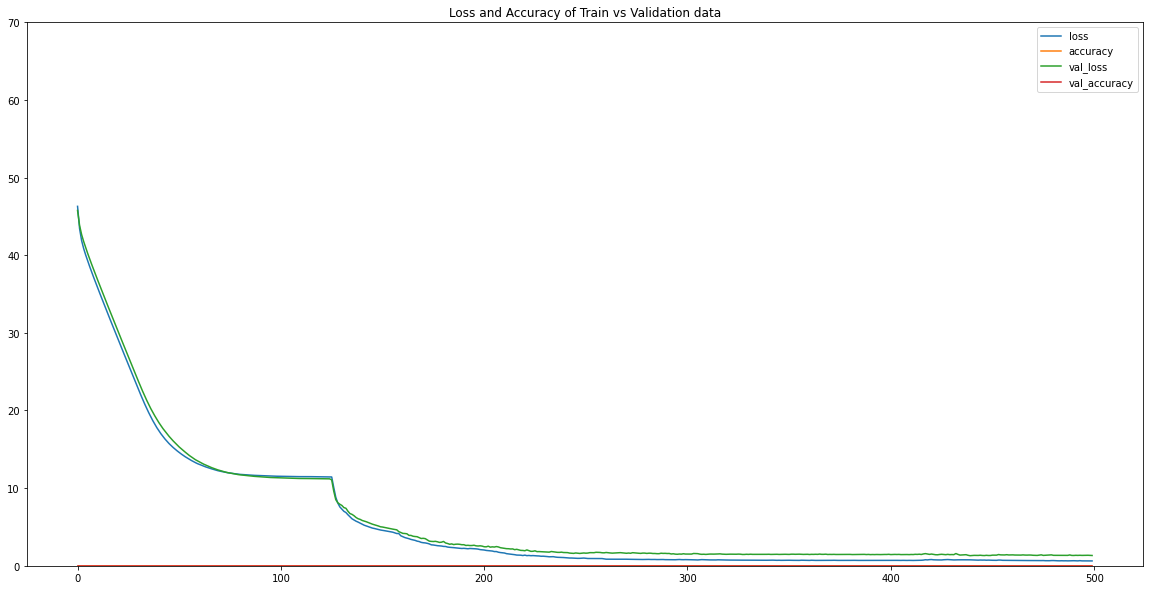

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [12]:
def plot_history(history, ylim=70): # Thank you catkins
    """
    Plot train and validation accuracy and loss in one chart.
    :param history: The dictionary containing the accuracy and loss history.
    """
    keep = ""
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Loss and Accuracy of Train vs Validation data')
    for key, value in history.history.items():
        ax.plot(value, label=key)
        print(f'Final {key}: {round(value[-1], 3)}')
        if key == "accuracy":
            keep = value
    plt.ylim([0,ylim])
    ax.legend()
    plt.show()
    return keep
plot_history(history)

In [13]:
# y_model = dt.models.convolutional(
#     input_shape=(101, 101, 1), 
#     number_of_outputs=1,
#     loss='mean_absolute_error',
#     optimiser='adam',
#     metrics=['mean_absolute_error', 'accuracy']
# )

# print("Model summary:")
# y_model.summary()

# print("Fitting the model")
# history = y_model.fit(
#     x=all_images,
#     y=y_dataset,
#     epochs=30,
#     validation_split=0.4
# )

# print("Model finished fitting")

In [15]:
# y_predicted = y_model.predict_on_batch(all_images)
# print(y_predicted)
# print(y_dataset)